In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import operator

In [2]:
BOARD_SIZE = 256
CELL_SIZE = 32 # 256/8
BLACK_THRESHOLD = 127 # nếu giá trị trung bình của matrix của CELL < BLACK_THRESHOLD thì cell là black

In [3]:
def preprocess_image(img,skip_dilate=False):
    img = cv2.GaussianBlur(img.copy(), (15, 15), 0)
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    img = cv2.bitwise_not(img, img)
    if not skip_dilate:
        kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]],np.uint8)
        img = cv2.dilate(img, kernel, iterations=1)
    return img

In [4]:
def find_corners_of_largest_polygon(img):
    #Finds the 4 extreme corners of the largest contour in the image.
    contours, h = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # Find external contours
    contours = sorted(contours, key=cv2.contourArea, reverse=True)  # Sort by area, descending
    polygon = contours[0]  # Largest image
    # Use of `operator.itemgetter` with `max` and `min` allows us to get the index of the point
    # Each point is an array of 1 coordinate, hence the [0] getter, then [0] or [1] used to get x and y respectively.

    # Bottom-right point has the largest (x + y) value
    # Top-left has point smallest (x + y) value
    # Bottom-left point has smallest (x - y) value
    # Top-right point has largest (x - y) value
    bottom_right, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_left, _ = min(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    bottom_left, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_right, _ = max(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))

    # Return an array of all 4 points using the indices
    # Each point is in its own array of one coordinate
    return [polygon[top_left][0], polygon[top_right][0], polygon[bottom_right][0], polygon[bottom_left][0]]

In [5]:
def distance_between(p1, p2):
    a = p2[0] - p1[0]
    b = p2[1] - p1[1]
    return np.sqrt((a ** 2) + (b ** 2))

def crop_and_warp(img, points):
    # Rectangle described by top left, top right, bottom right and bottom left points
    top_left, top_right, bottom_right, bottom_left = points[0], points[1], points[2], points[3]

    # Explicitly set the data type to float32 or `getPerspectiveTransform` will throw an error
    src = np.array([top_left, top_right, bottom_right, bottom_left], dtype='float32')

    # Get the longest side in the rectangle
    side = max([
        distance_between(bottom_right, top_right),
        distance_between(top_left, bottom_left),
        distance_between(bottom_right, bottom_left),
        distance_between(top_left, top_right)
    ])
    # Describe a square with side of the calculated length, this is the new perspective we want to warp to
    dst = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], dtype='float32')

    # Gets the transformation matrix for skewing the image to fit a square by comparing the 4 before and after points
    m = cv2.getPerspectiveTransform(src, dst)

    # Performs the transformation on the original image
    return cv2.warpPerspective(img, m, (int(side), int(side)))

In [6]:
def split_cells(img):
    squares = []
    side = img.shape[:1][0]/8
    for i in range(8):
        for j in range(8):
            p1 = (int(i * side), int(j * side))  # Top left corner of a bounding box
            p2 = (int((i + 1) * side), int((j + 1) * side))  # Bottom right corner of bounding box
            squares.append((p1, p2))
    return squares

In [7]:
def display_rects(in_img, rects, colour=255):
    """Displays rectangles on the image."""
    img = in_img.copy()
    for rect in rects:
        img = cv2.rectangle(img, tuple(int(x) for x in rect[0]), tuple(int(x) for x in rect[1]), colour)
    plt_show(img)

In [8]:
def plt_show(img,cmap='gray'):
    plt.imshow(img,cmap=cmap)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [9]:
def get_chessboard(filename):
    original_image = cv2.resize(cv2.imread(filename,0),(512,512))
    preprocessed_image = preprocess_image(original_image)
    
    plt.imshow (preprocessed_image)
    points = find_corners_of_largest_polygon(preprocessed_image)
    
    # remove board border by 7%
    cropped_image = crop_and_warp(original_image,points)
    chieucao, chieurong = cropped_image.shape
    five_percent = chieucao // 100 * 5
    cropped_image = cropped_image[five_percent: chieucao - five_percent, five_percent: chieurong - five_percent]
    cropped_image = cv2.resize(cropped_image, (BOARD_SIZE, BOARD_SIZE))
    
    fig = plt.figure(figsize=(10, 7))
    fig.add_subplot(1, 2, 1)
    plt.imshow(original_image,cmap='gray')
    plt.xticks([])
    plt.yticks([])
#     plt.axis('off')
    plt.title("Original Image")

    fig.add_subplot(1, 2, 2)
    plt.imshow(cropped_image,cmap='gray')
    plt.xticks([])
    plt.yticks([])
#     plt.axis('off')
    plt.title("Extracted ChessBoard")
    plt.show()
    return cropped_image
    

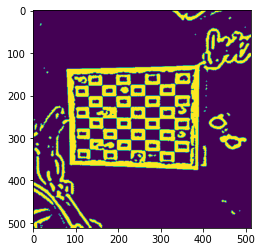

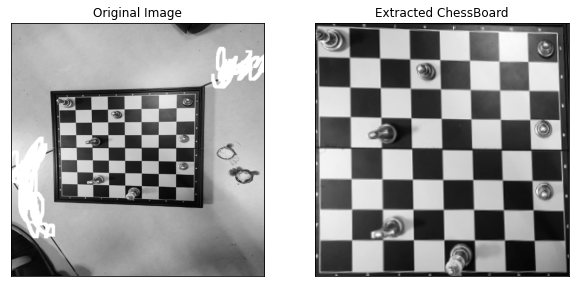

In [10]:
chessboard = get_chessboard('test5.jpg')

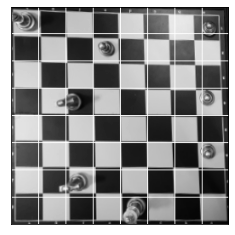

In [11]:
display_rects(chessboard,split_cells(chessboard))

In [12]:
cells = split_cells(chessboard)
print(len(cells))

64


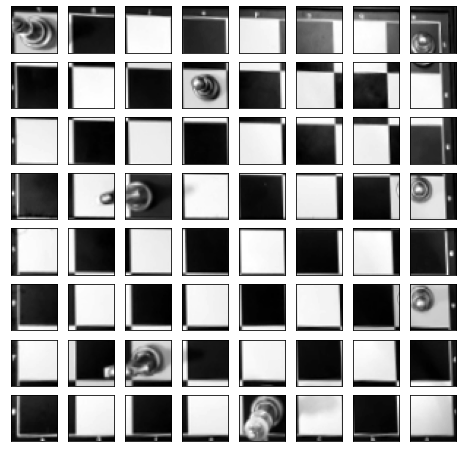

In [13]:
fig = plt.figure(figsize=(8, 8))
columns = 8
rows = 8
cells = split_cells(chessboard)
for i in range(64):
    cell = cells[i]
    (r1,c1),(r2,c2) = cell
    fig.add_subplot(rows, columns, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(chessboard[r1:r2,c1:c2],cmap='gray')
plt.show()

In [14]:
columns = 8
rows = 8
cells = split_cells(chessboard)

for i in range(rows):
    for j in range(columns):
        cell = cells[i * rows + j]
        (r1,c1),(r2,c2) = cell
        cell_img = chessboard[r1:r2,c1:c2]
        if cell_img.mean() < BLACK_THRESHOLD:
            print ("Black ", end='')
        else:
            print ("White ", end='')
    print ("")

Black Black White Black White Black White Black 
Black White Black White Black White White White 
White Black White Black White Black White Black 
Black White Black White Black White Black White 
White Black White Black White Black White Black 
Black White Black White Black White Black White 
White Black Black Black White Black White Black 
Black White Black White Black White Black Black 
